In [91]:
# Import required libraries

import re
import string
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

# NLTK
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
stemmer= PorterStemmer()
lemmit=WordNetLemmatizer()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,roc_auc_score

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to C:\Users\Bank of
[nltk_data]     America\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Bank of
[nltk_data]     America\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Bank of
[nltk_data]     America\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [92]:
# Import dataset

df=pd.read_csv('https://raw.githubusercontent.com/mohittomar2008/Rating-Prediction-over-reviews--NLP/main/review_comments_data.csv', index_col=0)
df.head(2)

Title                                             Review  \
0   Terrible product  Its only 7 months I bought this product. It wa...   
1  Absolute rubbish!          Automatically Disconnected so many times.   

   Rating  
0       1  
1       1

In [93]:
print("Dataset have ",df.shape[0] , 'rows and ', df.shape[1] ,'columns')

Dataset have  32431 rows and  3 columns


In [94]:
# We have 32,081 records and 3 features

In [95]:
df['Rating'].value_counts(normalize=True)

5    0.352348
1    0.253739
4    0.220561
3    0.104190
2    0.069162
Name: Rating, dtype: float64

In [96]:
df.duplicated().sum()

8164

In [97]:
# FIrst of all, we will remove duplicate entries which will not be usful for any prediction other than bias the model

df.drop_duplicates(inplace=True)

In [98]:
print("Dataset after removing duplicate entries is  ",df.shape[0] , 'rows and ', df.shape[1] ,'columns')

Dataset after removing duplicate entries is   24267 rows and  3 columns


In [99]:
df.sample(4)

Title                                             Review  Rating
14845  Very poor                                       Bad products       1
15479  Fabulous!  All ok @ 1799< with Extra 2 year warranty @ 69...       5
17574  Hated it!  After i month display blinking , very very fau...       1
3413   Must buy!                              All over nice product       5

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24267 entries, 0 to 32430
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   24266 non-null  object
 1   Review  24267 non-null  object
 2   Rating  24267 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 758.3+ KB


### Missing Values in Text data

In [101]:
df.isnull().sum()

Title     1
Review    0
Rating    0
dtype: int64

<AxesSubplot:>

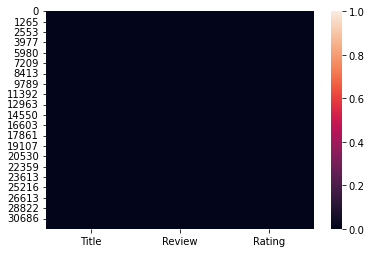

In [102]:
sns.heatmap(df.isnull())

We have only 1 null value in Title feature which is difficult to see in graph. As the missing value quantity is very less, we can drop this

In [103]:
df.dropna(inplace=True)

### Both Title and Review features are in Object datatype which should be in String datatype



In [104]:
df['Title']=df['Title'].astype('string')
df['Review']=df['Review'].astype('string')

In [105]:
df['title_len']= df['Title'].apply(lambda x:len(x))
df['review_len']= df['Review'].apply(lambda x:len(x))

In [106]:
df.sample(3)

Title                     Review  Rating  title_len  \
26058       Wonderful  Best laptop in this price       5          9   
20394  Unsatisfactory                    average       1         14   
13917          Super!     Very good products....       5          6   

       review_len  
26058          25  
20394           7  
13917          22

In [107]:
# Check any random input

df['Title'].loc[100]

'Worthless'

In [108]:
df['Review'].loc[100]

'Bluetooth connectivity is very poor..\nAfter on or off bluetooth not connect to mobile'

In [109]:
df.head(1)

Title                                             Review  \
0  Terrible product  Its only 7 months I bought this product. It wa...   

   Rating  title_len  review_len  
0       1         16         357

### Text Preprocessing

## Steps to Follow:
    Remove all email addresses
    Remove all website links if any
    Capture emojis
    Remove all special character
    
    Convert into lower case
    Stemmer/Lemmitizer to convert into base word

In [110]:
# we are going to concat Title and Review features

df['comment']=df['Title']+' '+ df['Review']
df.head(2)

Title                                             Review  \
0   Terrible product  Its only 7 months I bought this product. It wa...   
1  Absolute rubbish!          Automatically Disconnected so many times.   

   Rating  title_len  review_len  \
0       1         16         357   
1       1         17          41   

                                             comment  
0  Terrible product Its only 7 months I bought th...  
1  Absolute rubbish! Automatically Disconnected s...

In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24266 entries, 0 to 32430
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Title       24266 non-null  string
 1   Review      24266 non-null  string
 2   Rating      24266 non-null  int64 
 3   title_len   24266 non-null  int64 
 4   review_len  24266 non-null  int64 
 5   comment     24266 non-null  string
dtypes: int64(3), string(3)
memory usage: 1.8 MB


In [112]:
# Anyhow we are going to analyse words being used to determine whether the comment is good or bad.

In [113]:
#stopwords=stopwords.words('english')

In [114]:
type(stopwords)

nltk.corpus.reader.wordlist.WordListCorpusReader

In [115]:
#stopwords.remove('not')  # remove 'not from stopwords'

In [116]:
print(stopwords)

<WordListCorpusReader in 'C:\\Users\\Bank of America\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>


### Handle Emoji's first

In [117]:
# !pip install emot

In [118]:
import re
import pickle

from emot.emo_unicode import UNICODE_EMOJI # For emojis
from emot.emo_unicode import EMOTICONS_EMO # For EMOTICONS

### Handling Emojis

In [119]:
# 'Emoji_Dict.p'- download link https://drive.google.com/open?id=1G1vIkkbqPBYPKHcQ8qy0G2zkoab2Qv4v

with open('Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word(text):
    for emot in Emoji_Dict:
        text = re.sub(r'('+emot+')', "_".join(Emoji_Dict[emot].replace(",","").replace(":","").split()), text)
    return text

text = "I won 🥇 in 🏏"
convert_emojis_to_word(text)

'I won 1st_place_medal in cricket'

In [120]:
type(text)

str

In [121]:
Emoji_Dict.keys

<function dict.keys>

In [122]:
type(df['comment'][0])

str

In [123]:
df['comment']

0        Terrible product Its only 7 months I bought th...
1        Absolute rubbish! Automatically Disconnected s...
2        Worst experience ever! everything is good expe...
3        Worst experience ever! Worst Product Quality E...
4                                Very poor Bakwas flipkart
                               ...                        
32424                               Just okay I love it 😍😍
32425                   Decent product Volume not expected
32428    Good I paid extra for stand. Because no hangin...
32429                                  Nice Damage project
32430           Just okay Product is good in this price...
Name: comment, Length: 24266, dtype: string

In [124]:
x_train,x_test,y_train,y_test=train_test_split(df['comment'],df['Rating'],test_size=.3,random_state=42)

In [125]:
x_train.shape , x_test.shape

((16986,), (7280,))

In [126]:
y_train.shape, y_test.shape

((16986,), (7280,))

In [127]:
df=df.reset_index()  # because we have deleted duplicate values

## Data Preprocessing

In [128]:
corpus=[]

for i in range(len(df)):
    review=re.sub('([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)',' ',df['comment'][i])
    review=re.sub('[^a-zA-Z]',' ',df['comment'][i])
    review=review.lower()
    review=review.split()
    
    review=[lemmit.lemmatize(word) for word in review if word not in set(stopwords.words('english'))]
    review=" ".join(review)
    corpus.append(review)

In [135]:
corpus

['terrible product month bought product convenient use sound bass everything good said water sweat resistance power never worked wearing splashed water still one side stopped working second without warning feel like wasted money wired earphone work longer',
 'absolute rubbish automatically disconnected many time',
 'worst experience ever everything good expect built quality built quality poor another disadvantage use earphone feel pain ear bcz heavy specially right side bud bcz heavy microphone charge socket run bcz due weight stick ear thanks',
 'worst experience ever worst product quality ever stop working one side day',
 'poor bakwas flipkart',
 'poor bad sound quality',
 'poor month used right side speaker working',
 'waste money bad experience sound problem e u call someone person hear u replacement option return acceptable',
 'hated side stopped working day know',
 'meet expectation bad',
 'utterly disappointed fitting earphone good sound ok main issue fitting product worst fitti

## Lets convert Words into vectors

# TF-IDF

In [136]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
X=tf.fit_transform(corpus).toarray()

In [137]:
X.shape

(24266, 8297)

In [138]:
Y=df['Rating']
Y

0        1
1        1
2        1
3        1
4        1
        ..
24261    3
24262    3
24263    3
24264    3
24265    3
Name: Rating, Length: 24266, dtype: int64

# Machine Learning

In [139]:
# Train and Test split

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=.3,stratify=Y,random_state=42)

In [140]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((16986, 8297), (7280, 8297), (16986,), (7280,))

## MultinomialNB

In [45]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(x_train, y_train)

In [46]:
#prediction
y_pred=spam_detect_model.predict(x_test)

In [47]:
score=accuracy_score(y_test,y_pred)
print(score)

0.789010989010989


In [48]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           1       0.98      0.82      0.89      2629
           2       0.35      0.99      0.52       220
           3       0.39      0.97      0.56       298
           4       0.58      0.79      0.67      1043
           5       0.98      0.73      0.84      3090

    accuracy                           0.79      7280
   macro avg       0.66      0.86      0.70      7280
weighted avg       0.88      0.79      0.81      7280



As this is imbalanced dataset, we will not focus on score while focus on Precision and Recall

## Logistic Regression

In [141]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression().fit(x_train, y_train)

In [142]:
#prediction
y_pred=LR_model.predict(x_test)

In [143]:
score=accuracy_score(y_test,y_pred)
print(score)

0.9114010989010989


In [144]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           1       0.99      0.96      0.97      2257
           2       0.79      0.94      0.86       519
           3       0.78      0.89      0.83       647
           4       0.84      0.85      0.84      1426
           5       0.96      0.91      0.93      2431

    accuracy                           0.91      7280
   macro avg       0.87      0.91      0.89      7280
weighted avg       0.92      0.91      0.91      7280



With Logistic Regression we acheived 91% accuracy

#  Balancing Dataset with augmentation

In [49]:
# ! pip install transformers
# ! pip install nlpaug

In [50]:
import nlpaug.augmenter.word.context_word_embs as aug

In [51]:
sample_text= df['comment'].iloc[101]
sample_text

'Useless product Hated hated hated'

In [52]:
augmenter=aug.ContextualWordEmbsAug(model_path='bert-base-uncased',action="insert")

In [53]:
# conda activate env_pytorch
# pip install torchvision 
#!! conda install -c pytorch pytorch

In [54]:
conda activate myenv


Note: you may need to restart the kernel to use updated packages.



EnvironmentNameNotFound: Could not find conda environment: myenv
You can list all discoverable environments with `conda info --envs`.




In [55]:
import torch
import torchvision

In [56]:
augmenter.augment(sample_text)

['useless product she hated hated products hated']

In [57]:
for i in range(5):
    print(augmenter.augment(sample_text))

['useless product that hated enemies hated hated']
['perfect useless finished product hated hated hated']
['useless product hated thing hated useless hated']
['useless beauty product hate hated hated hated']
['most useless product hated hated hated hated']


In [58]:
df['Rating'].value_counts()

5    7686
1    7282
4    4782
3    2463
2    2053
Name: Rating, dtype: int64

## SMOTE

In [145]:
X.shape , Y.shape

((24266, 8297), (24266,))

In [146]:
Y.value_counts()

5    7686
1    7282
4    4782
3    2463
2    2053
Name: Rating, dtype: int64

In [147]:
from imblearn.over_sampling import SMOTE
sm=SMOTE()

x,y=sm.fit_resample(X,Y)

In [148]:
y.value_counts()

1    7686
5    7686
4    7686
3    7686
2    7686
Name: Rating, dtype: int64

In [149]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.3,random_state=42)

In [150]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression().fit(x_train, y_train)

In [151]:
#prediction
y_pred=LR_model.predict(x_test)

In [152]:
score=accuracy_score(y_test,y_pred)
print(score)

0.9246248590510886


So balancing data worked preety well to increase score by 1%

<AxesSubplot:>

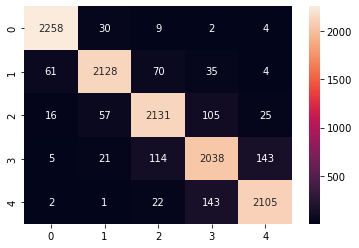

In [153]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True, fmt='d')

## ROC-AUC curve

In [155]:
y_pred_prob=LR_model.predict_proba(x_test)

In [156]:
roc_auc_score(y_test,y_pred_prob,multi_class='ovr', average='weighted')

0.990397383130343

In [158]:
from sklearn.metrics import roc_auc_score,roc_curve

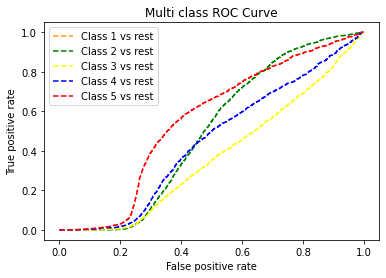

In [161]:
fpr={}
tpr={}
threshold={}

n_class=5

for i in range(n_class):
    fpr[i],tpr[i],threshold[i]=roc_curve(y_test,y_pred_prob[:,i],pos_label=i)
    
#plotting
plt.plot(fpr[0],tpr[0],linestyle='--', color='orange',label='Class 1 vs rest'  )
plt.plot(fpr[1],tpr[1],linestyle='--', color='green',label='Class 2 vs rest'  )
plt.plot(fpr[2],tpr[2],linestyle='--', color='yellow',label='Class 3 vs rest'  )
plt.plot(fpr[3],tpr[3],linestyle='--', color='blue',label='Class 4 vs rest'  )
plt.plot(fpr[4],tpr[4],linestyle='--', color='red',label='Class 5 vs rest'  )
plt.title('Multi class ROC Curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()

## Hypertuning

SyntaxError: invalid syntax (1411060081.py, line 1)

In [175]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1','l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)

In [177]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [170]:
#rf_random = RandomizedSearchCV(estimator = LR_model, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [179]:
grid_search = GridSearchCV(estimator=LR_model, param_grid=grid, n_jobs=-1,cv=cv ,scoring='accuracy',error_score=0)



In [ ]:
grid_result=grid_search.fit(X,Y)


In [ ]:
# Its taking too much time

In [ ]:
import joblib
joblib.dump(LR_model,"Rating Prediction.pkl")

# Decission Tree

In [86]:
from sklearn.tree import DecisionTreeClassifier

dt=DecisionTreeClassifier().fit(x_train,y_train)
y_pred=dt.predict(x_test)

score=accuracy_score(y_test,y_pred)
score

0.8965218145546014

In [87]:
from sklearn.neighbors import KNeighborsClassifier

dt=KNeighborsClassifier().fit(x_train,y_train)
y_pred=dt.predict(x_test)

score=accuracy_score(y_test,y_pred)
score

0.7948651227339751

# SVC

In [89]:
from sklearn.svm import SVC

dt=SVC().fit(x_train,y_train)
y_pred=dt.predict(x_test)

score=accuracy_score(y_test,y_pred)
score

KeyboardInterrupt: 